<a href="https://colab.research.google.com/github/MiriamRunde/Qbias/blob/main/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
!pip install datasets
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
# Load the MBIB political bias dataset
dataset_dict = load_dataset("mediabiasgroup/mbib-base")
political_dataset = dataset_dict['political_bias']

# Convert to a Pandas DataFrame
data = political_dataset.to_pandas()
print(data.head)

# Preprocess the data
data = data[['text', 'label']]  # Select relevant columns
#data = data.dropna()  # Remove NaN rows


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

mbib-aggregated/cognitive-bias.csv:   0%|          | 0.00/851k [00:00<?, ?B/s]

mbib-aggregated/fake-news.csv:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

mbib-aggregated/gender-bias.csv:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

hate-speech.csv:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

linguistic-bias.csv:   0%|          | 0.00/121M [00:00<?, ?B/s]

mbib-aggregated/political-bias.csv:   0%|          | 0.00/4.32M [00:00<?, ?B/s]

mbib-aggregated/racial-bias.csv:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

mbib-aggregated/text-level-bias.csv:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating cognitive_bias split:   0%|          | 0/7092 [00:00<?, ? examples/s]

Generating fake_news split:   0%|          | 0/8542 [00:00<?, ? examples/s]

Generating gender_bias split:   0%|          | 0/17940 [00:00<?, ? examples/s]

Generating hate_speech split:   0%|          | 0/339010 [00:00<?, ? examples/s]

Generating linguistic_bias split:   0%|          | 0/401862 [00:00<?, ? examples/s]

Generating political_bias split:   0%|          | 0/17704 [00:00<?, ? examples/s]

Generating racial_bias split:   0%|          | 0/9788 [00:00<?, ? examples/s]

Generating text_level_bias split:   0%|          | 0/9018 [00:00<?, ? examples/s]

<bound method NDFrame.head of                     id                                               text  \
0        029-0000067-5                               Sebastian Gorka Yes    
1       029-0000200-13  Suddenly his powerful former friends are retur...   
2        029-0001194-6   Malia Obama s private life as a young woman a...   
3       029-0000412-10  Jerry Springer I mean good God Other than his ...   
4        029-0000063-2  Jerry Drake Varnell of Sayre was arrested Augu...   
...                ...                                                ...   
17699   029-0000926-58                          Jim Acosta August 22 2017   
17700  029-0000879-120  Because Liz offers a ridiculously good guarant...   
17701   029-0000898-36                                 So great so great    
17702    029-0000094-8  On Forbes list of highest earning athletes bla...   
17703   029-0001030-16                  Charles Hoskinson October 13 2017   

       label  dataset_id  
0          0      

In [6]:

# Split into training and evaluation datasets
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)

In [7]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# In your BiasDataset class's __getitem__ method:
class BiasDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Check if the text is valid before tokenizing
        text = self.texts.iloc[idx]
        if not isinstance(text, str) or not text:  # Check if text is a non-empty string
            text = ""  # or any default value you want to use

        tokenized_data = tokenizer(
            text,  # Use the checked text
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(0),
            "attention_mask": tokenized_data["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Create PyTorch datasets
train_dataset = BiasDataset(train_texts, train_labels)
eval_dataset = BiasDataset(eval_texts, eval_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Training: 100%|██████████| 886/886 [09:16<00:00,  1.59it/s, loss=0.201]


Epoch 1, Loss: 0.5412162380213124


Evaluating: 100%|██████████| 222/222 [00:47<00:00,  4.66it/s]


Precision: 0.8475, Recall: 0.5892, F1 Score: 0.6951


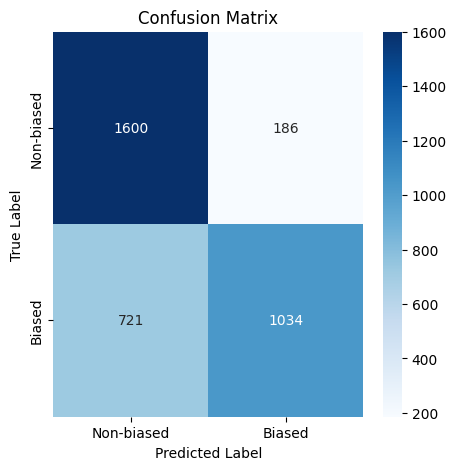

Epoch 2 Training: 100%|██████████| 886/886 [09:17<00:00,  1.59it/s, loss=0.26]


Epoch 2, Loss: 0.4152561154460396


Evaluating: 100%|██████████| 222/222 [00:47<00:00,  4.67it/s]


Precision: 0.8672, Recall: 0.5880, F1 Score: 0.7008


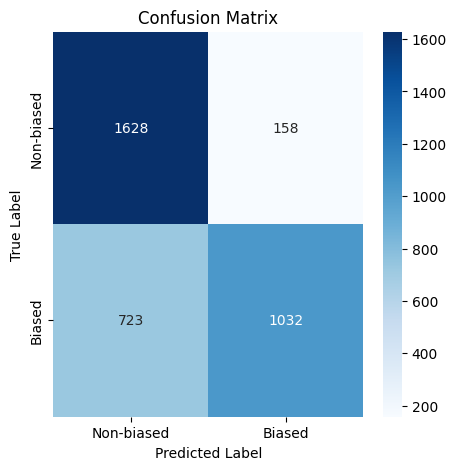

Epoch 3 Training:  42%|████▏     | 373/886 [03:54<05:22,  1.59it/s, loss=0.355]

In [ ]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Load the pretrained RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training function
def train_model(model, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")

    for batch in progress_bar:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation function
def evaluate_model(model, eval_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(eval_loader, desc="Evaluating")

    with torch.no_grad():
        for batch in progress_bar:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Ensure valid input for the model
            if input_ids.size(0) == 0:
                continue

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Display confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-biased", "Biased"], yticklabels=["Non-biased", "Biased"])
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

# Train and evaluate the model
epochs = 3
for epoch in range(epochs):
    train_model(model, train_loader, optimizer, epoch)
    evaluate_model(model, eval_loader)

# Save the fine-tuned model
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

print("Fine-tuning complete. Model saved to 'fine_tuned_roberta'.")


In [19]:
# Load fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_roberta").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_roberta")

# Function to make predictions
def make_predictions(texts, model, tokenizer):
    results = []
    for text in texts:
        # Check if the text is a valid string
        if isinstance(text, str) and text.strip():
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
            with torch.no_grad():
                logits = model(**inputs).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                predicted_label = probs.argmax()
                confidence = probs[predicted_label]

            results.append({
                "text": text,
                "predicted_label": predicted_label,
                "confidence": confidence
            })
        else:
            # Handle invalid text (e.g., None or empty string)
            results.append({
                "text": text,  # Or you can use a placeholder like "[EMPTY]"
                "predicted_label": -1,  # Or any other value to indicate invalid
                "confidence": 0.0  # Or a value indicating low confidence
            })
    return pd.DataFrame(results)


# Clean the text data
texts = [text if isinstance(text, str) and text.strip() else "[EMPTY]" for text in data['text'].tolist()]
actual_labels = data['label'].tolist()

# Make predictions
texts = data['text'].tolist()
actual_labels = data['label'].tolist()
predictions_df = make_predictions(texts, model, tokenizer)

# Add actual labels to predictions
predictions_df["actual_label"] = actual_labels
predictions_df.to_csv("predictions_with_labels.csv", index=False)


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install captum
from captum.attr import LayerIntegratedGradients, visualization
import torch

# Load the fine-tuned RoBERTa model and tokenizer
checkpoint = "fine_tuned_roberta"  # Replace with the path to your model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to("cuda")
model.eval()

# Define the forward function for Captum
def forward_func(inputs, attention_mask=None):
    output = model(input_ids=inputs, attention_mask=attention_mask)
    return output.logits

# Initialize Layer Integrated Gradients
lig = LayerIntegratedGradients(forward_func, model.roberta.embeddings)
# ... (previous code) ...

# Compute attributions for a given text
def compute_attributions(text, label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Reference baseline (all zeros)
    reference_input_ids = torch.zeros_like(input_ids)

    # Compute attributions
    # Change 'target' to a tensor
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=reference_input_ids,
        additional_forward_args=(attention_mask,),
        n_steps=50,
        return_convergence_delta=True,
        target=torch.tensor([label]).to("cuda")  # Convert label to a tensor
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    return tokens, attributions, delta

# ... (rest of the code) ...

# Summarize attributions for each token
def summarize_attributions(attributions):
    attributions = attributions / (abs(attributions).max() + 1e-10)
    return attributions

# Visualize attributions
def visualize_attributions(text, pred_label, true_label, pred_prob):
    tokens, raw_attributions, delta = compute_attributions(text, pred_label)
    normalized_attributions = summarize_attributions(raw_attributions)

    # Visualization data
    viz_info = visualization.VisualizationDataRecord(
        word_attributions=normalized_attributions.tolist(),
        pred_prob=pred_prob,
        pred_class=pred_label,
        true_class=true_label,
        attr_class=pred_label,
        attr_score=normalized_attributions.sum(),
        raw_input_ids=tokens,
        convergence_score=delta
    )

    # Save the visualization to an HTML file
    html = visualization.visualize_text([viz_info])
    with open("captum_viz.html", "w") as f:
        f.write(html.data)

    print("Visualization saved to 'captum_viz.html'.")

# Apply to one example
example_text = data.loc[0, "text"]  # Replace with a valid text from your dataset
example_label = data.loc[0, "label"]  # Replace with the actual label
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_label = probs.argmax()
    pred_prob = probs[pred_label]

# Generate visualization
visualize_attributions(example_text, pred_label, example_label, pred_prob)


SafetensorError: Error while deserializing header: MetadataIncompleteBuffer

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install captum
from captum.attr import LayerIntegratedGradients, visualization
import torch

# Ensure model and tokenizer match your fine-tuned setup
checkpoint = "fine_tuned_roberta"  # Replace with your fine-tuned model checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.to("cuda")
model.eval()

# Define forward function for Captum
def forward_func(inputs, attention_mask=None):
    output = model(input_ids=inputs, attention_mask=attention_mask)
    return output.logits

# Initialize Layer Integrated Gradients
lig = LayerIntegratedGradients(forward_func, model.roberta.embeddings)

# Compute attributions for a given example
def compute_attributions_for_example(text, true_label, target_label):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Define reference inputs (all zeros)
    reference_input_ids = torch.zeros_like(input_ids)

    # Compute attributions
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=reference_input_ids,
        additional_forward_args=(attention_mask,),
        n_steps=50,
        return_convergence_delta=True,
        target=target_label
    )

    # Convert tokens to human-readable form
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    return tokens, attributions, delta

# Summarize attributions for visualization
def summarize_attributions(attributions):
    return attributions / (torch.norm(torch.tensor(attributions)) + 1e-10)

# Visualize attributions
def visualize_attributions(text, true_label, pred_label, pred_prob):
    tokens, raw_attributions, delta = compute_attributions_for_example(text, true_label, pred_label)
    normalized_attributions = summarize_attributions(raw_attributions)

    # Prepare visualization data
    viz_info = visualization.VisualizationDataRecord(
        word_attributions=normalized_attributions.tolist(),
        pred_prob=pred_prob,
        pred_class=pred_label,
        true_class=true_label,
        attr_class=pred_label,
        attr_score=normalized_attributions.sum(),
        raw_input_ids=tokens,
        convergence_score=delta
    )

    # Save the visualization to an HTML file
    html = visualization.visualize_text(datarecords=[viz_info])
    with open("captum_viz.html", "w") as f:
        f.write(html.data)

    print("Visualization saved to 'captum_viz.html'.")

# Iterate over your dataset and generate visualizations
for i, row in results_df.iterrows():
    text = row["text"]
    true_label = row["true_label"]
    pred_label = row["predicted_label"]

    # Tokenize and compute prediction probability
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    logits = model(**inputs).logits
    pred_prob = torch.softmax(logits, dim=-1)[0, pred_label].item()

    # Generate visualization
    try:
        visualize_attributions(text, true_label, pred_label, pred_prob)
    except Exception as e:
        print(f"Error processing example {i}: {e}")

    # Stop after testing a few examples
    if i >= 2:  # Change to process more examples
        break


NameError: name 'results_df' is not defined

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode sentences into embeddings
train_embeddings = sbert_model.encode(train_texts.tolist(), show_progress_bar=True)
eval_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Compute cosine similarity for a sample
sample_sentence = "The policy clearly favors certain groups."
sample_embedding = sbert_model.encode([sample_sentence])
cos_sim = cosine_similarity(sample_embedding, eval_embeddings)

# Find the most similar sentence in the evaluation dataset
most_similar_idx = np.argmax(cos_sim)
print(f"Input Sentence: {sample_sentence}")
print(f"Most Similar Sentence: {eval_texts.iloc[most_similar_idx]}")
print(f"Similarity Score: {cos_sim[0, most_similar_idx]:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches: 100%|██████████| 111/111 [00:27<00:00,  4.04it/s]

Input Sentence: The policy clearly favors certain groups.
Most Similar Sentence: The ruling class promotes with its foundations the use of white privilege rhetoric as I show in great detail here and counts on the Left not explaining as I do here that white privilege is a phrase designed to hide the truth that AN INJURY TO ONE IS AN INJURY TO ALL On the contrary the Left is largely responsible for the sad fact that young people today use the horribly misleading phrase white privilege to refer to what the Martin Luther King Jr Civil Rights Movement referred to with the very good phrase racial discrimination The result is that working class people are being effectively divided and ruled along race lines as I discuss here 
Similarity Score: 0.4250


In [ ]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# Load sentence embeddings using Sentence-BERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Apply K-Means clustering
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Add cluster labels to the evaluation dataset
eval_texts_with_labels = eval_texts.to_frame(name="text")
eval_texts_with_labels["cluster"] = cluster_labels

print(eval_texts_with_labels)



Batches: 100%|██████████| 111/111 [00:27<00:00,  4.02it/s]


                                                    text  cluster
17699                          Jim Acosta August 22 2017        1
1527   More than 200 players either knelt or used oth...        1
9264   I am the daughter of an immigrant amp a daught...        1
15404   That somehow this bill is jeopardized by the ...        0
3752   While the president has complained that Comey ...        0
...                                                  ...      ...
11759  The firing of the director of strategic planni...        0
9887   OK what about the Alt Left that came charging ...        1
13528  It was the EU filled with an imperialist ambit...        0
12034  The first step toward fulfilling our duty is t...        1
13326   You cannot find a reasonable health care anal...        0

[3541 rows x 2 columns]


In [ ]:
# Add ground truth labels to the DataFrame
eval_texts_with_labels["true_label"] = eval_labels.values

# Map clusters to dominant true labels
cluster_to_label = eval_texts_with_labels.groupby("cluster")["true_label"].agg(lambda x: x.value_counts().idxmax())
print(f"Cluster to Label Mapping:\n{cluster_to_label}")


Cluster to Label Mapping:
cluster
0    1
1    0
Name: true_label, dtype: int64


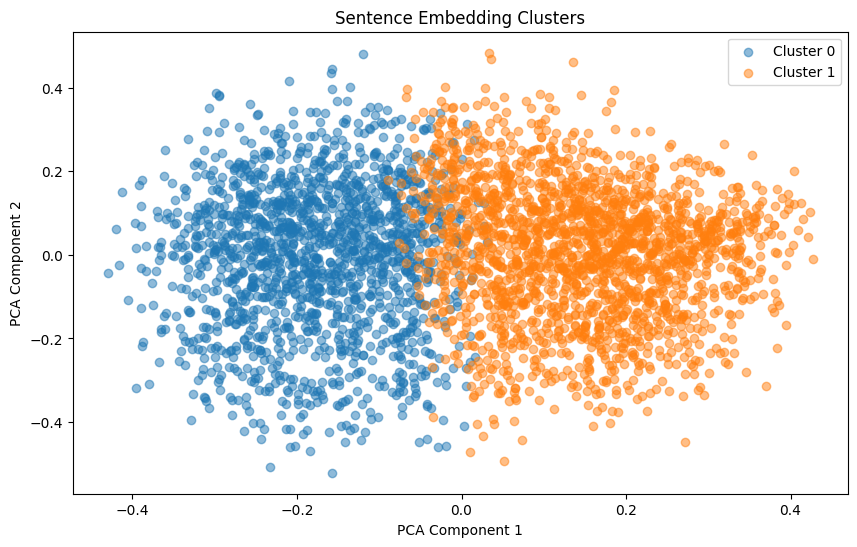

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.5)
plt.legend()
plt.title("Sentence Embedding Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# Load sentence embeddings using Sentence-BERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Apply K-Means clustering
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Add cluster labels and true labels to a DataFrame
eval_texts_with_labels = pd.DataFrame({
    "text": eval_texts,
    "true_label": eval_labels,
    "cluster": cluster_labels
})




Batches: 100%|██████████| 111/111 [00:27<00:00,  4.02it/s]


In [ ]:
# Group by cluster and analyze label distribution
for cluster_id in range(num_clusters):
    cluster_data = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]
    label_counts = cluster_data["true_label"].value_counts()
    print(f"Cluster {cluster_id}:")
    print(label_counts)
    print("\n")


Cluster 0:
true_label
1    989
0    606
Name: count, dtype: int64


Cluster 1:
true_label
0    1180
1     766
Name: count, dtype: int64




In [ ]:
# Calculate purity
total_samples = len(eval_texts_with_labels)
purity = 0

for cluster_id in range(num_clusters):
    cluster_data = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]
    majority_label_count = cluster_data["true_label"].value_counts().max()
    purity += majority_label_count

purity /= total_samples
print(f"Cluster Purity: {purity:.4f}")


Cluster Purity: 0.6125


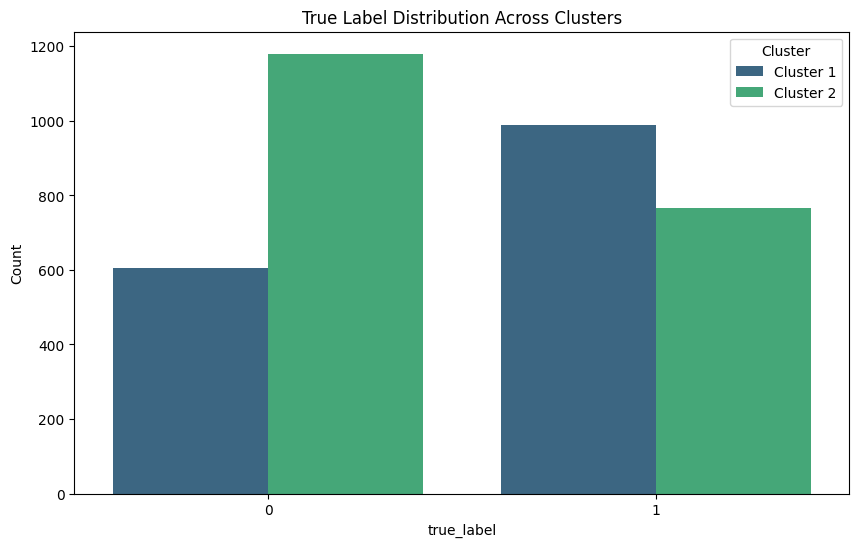

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot label distribution for each cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=eval_texts_with_labels, x="true_label", hue="cluster", palette="viridis")
plt.title("True Label Distribution Across Clusters")
plt.xlabel("true_label")
plt.ylabel("Count")
plt.legend(title="Cluster", labels=["Cluster 1", "Cluster 2"])
plt.show()


In [ ]:
# Group sentences by cluster
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_sentences = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]["text"]
    print(cluster_sentences)  # Print first 5 sentences in this cluster
    print("\n")


Cluster 0:
15404     That somehow this bill is jeopardized by the ...
3752     While the president has complained that Comey ...
15942    She went on to say it was one thousand times w...
2051     The Republican nominee added that he also isn ...
4124      In connection with an unrelated case the FBI ...
                               ...                        
9669     In a Twitter thread the political aspirant voi...
2798     But it seems that Affleck won t actually be le...
11759    The firing of the director of strategic planni...
13528    It was the EU filled with an imperialist ambit...
13326     You cannot find a reasonable health care anal...
Name: text, Length: 1595, dtype: object


Cluster 1:
17699                            Jim Acosta August 22 2017
1527     More than 200 players either knelt or used oth...
9264     I am the daughter of an immigrant amp a daught...
11517    Key Fact In most states including North Caroli...
6201                         Matthew A Cherry June 

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(train_texts)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Analyze top features for biased and non-biased texts
biased_indices = np.where(train_labels == 1)[0]
non_biased_indices = np.where(train_labels == 0)[0]

biased_tfidf = tfidf_matrix[biased_indices].mean(axis=0).A1
non_biased_tfidf = tfidf_matrix[non_biased_indices].mean(axis=0).A1

# Top features
top_biased_indices = np.argsort(biased_tfidf)[::-1][:10]
top_non_biased_indices = np.argsort(non_biased_tfidf)[::-1][:10]

print("Top Biased Terms:")
for idx in top_biased_indices:
    print(f"{feature_names[idx]}: {biased_tfidf[idx]:.4f}")

print("\nTop Non-Biased Terms:")
for idx in top_non_biased_indices:
    print(f"{feature_names[idx]}: {non_biased_tfidf[idx]:.4f}")


Top Biased Terms:
trump: 0.0470
people: 0.0230
president: 0.0224
clinton: 0.0202
like: 0.0169
just: 0.0159
said: 0.0157
hillary: 0.0146
america: 0.0134
american: 0.0126

Top Non-Biased Terms:
said: 0.0332
trump: 0.0252
clinton: 0.0181
people: 0.0179
president: 0.0171
police: 0.0171
2017: 0.0149
news: 0.0121
just: 0.0114
time: 0.0109


In [ ]:
pip install textblob nltk vaderSentiment seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from textblob import TextBlob
from nltk import pos_tag, word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def extract_features(text):
    # Ensure the text is valid
    if not isinstance(text, str) or not text.strip():
        return [0, 0, 0, 0]  # Default feature values for invalid text

    # Sentiment and polarity
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity  # Range [-1, 1]
    sentiment_subjectivity = blob.sentiment.subjectivity  # Range [0, 1]

    # VADER emotionality scores
    vader_scores = analyzer.polarity_scores(text)
    compound_sentiment = vader_scores["compound"]  # Overall sentiment score

    # Count adjectives
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    num_adjectives = sum(1 for word, tag in pos_tags if tag.startswith("JJ"))  # Adjectives

    # Feature vector
    return [
        sentiment_polarity,
        sentiment_subjectivity,
        compound_sentiment,
        num_adjectives
    ]

# Ensure no missing values in the dataset
df = eval_texts_with_labels.dropna(subset=["text", "true_label"])

# Apply feature extraction to the dataset
features = df["text"].apply(extract_features).tolist()

# Create the feature DataFrame and add true labels
feature_df = pd.DataFrame(features, columns=["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"])
feature_df["True Label"] = df["true_label"].values  # Add true labels


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
print(feature_df)

      Polarity  Subjectivity  Compound Sentiment  Num Adjectives  True Label
0     0.000000      0.000000              0.0000               0           1
1     0.093750      0.360417              0.1877               4           0
2     0.500000      0.500000              0.8126               3           1
3     0.000000      0.000000             -0.0258               0           1
4     0.004167      0.429167             -0.8885               6           0
...        ...           ...                 ...             ...         ...
3535 -0.031250      0.218750              0.0258               6           1
3536 -0.031994      0.320089             -0.8204               4           1
3537  0.300000      0.500000             -0.2732               4           1
3538  0.045000      0.305833             -0.5574               7           1
3539 -0.005000      0.475000              0.6808               4           1

[3540 rows x 5 columns]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

# Apply K-Means clustering
num_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
feature_df["Cluster"] = cluster_labels
eval_texts_with_clusters = eval_texts.to_frame(name="text")
eval_texts_with_clusters["Cluster"] = cluster_labels


/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecate

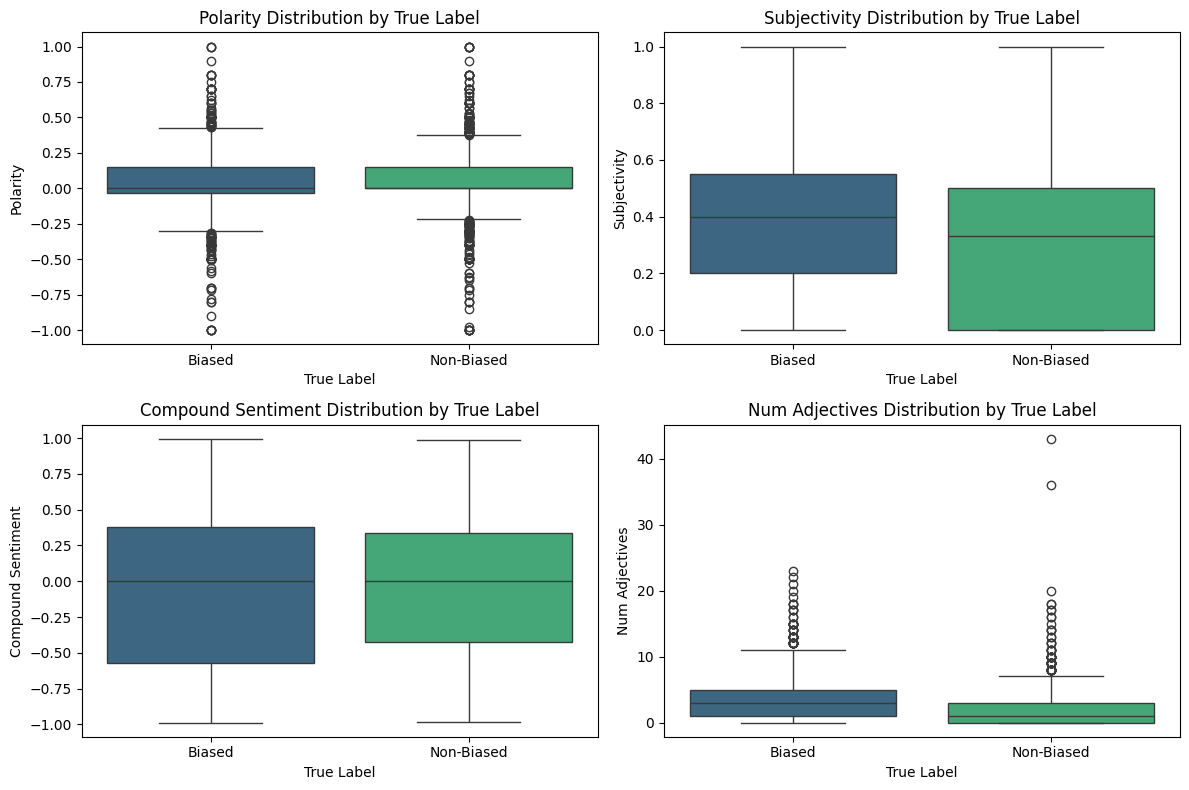

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map true labels to human-readable categories
feature_df["True Label"] = feature_df["True Label"].map({1: "Biased", 0: "Non-Biased"})

# Set up the plotting environment
plt.figure(figsize=(12, 8))

# Plot each feature
for i, column in enumerate(["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"], 1):
    plt.subplot(2, 2, i)  # Arrange subplots in a 2x2 grid
    sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
    plt.title(f"{column} Distribution by True Label")
    plt.xlabel("True Label")
    plt.ylabel(column)

plt.tight_layout()
plt.show()


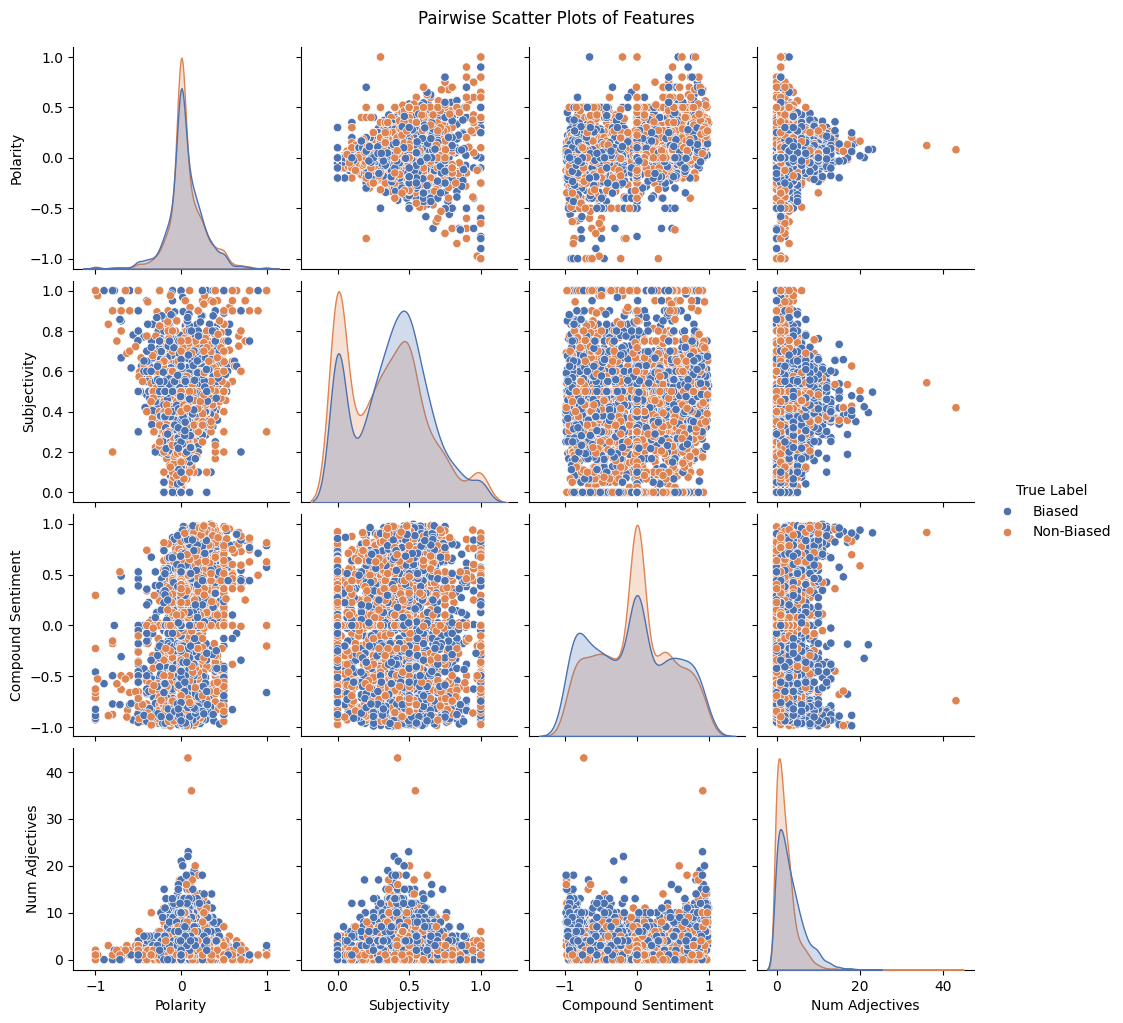

In [ ]:
sns.pairplot(
    feature_df,
    hue="True Label",
    vars=["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"],
    palette="deep",
    diag_kind="kde"
)
plt.suptitle("Pairwise Scatter Plots of Features", y=1.02)
plt.show()


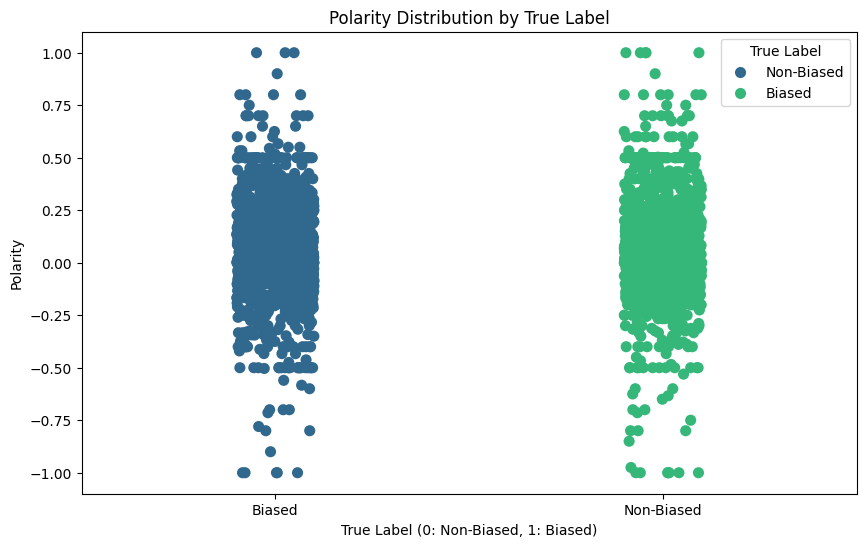

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot with True Label on the x-axis
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=feature_df,
    x="True Label",
    y="Polarity",
    hue="True Label",
    palette="viridis",
    jitter=True,  # Add jitter for better visualization
    size=8,  # Size of points
    dodge=False
)
plt.title("Polarity Distribution by True Label")
plt.xlabel("True Label (0: Non-Biased, 1: Biased)")
plt.ylabel("Polarity")
plt.legend(title="True Label", labels=["Non-Biased", "Biased"])
plt.show()


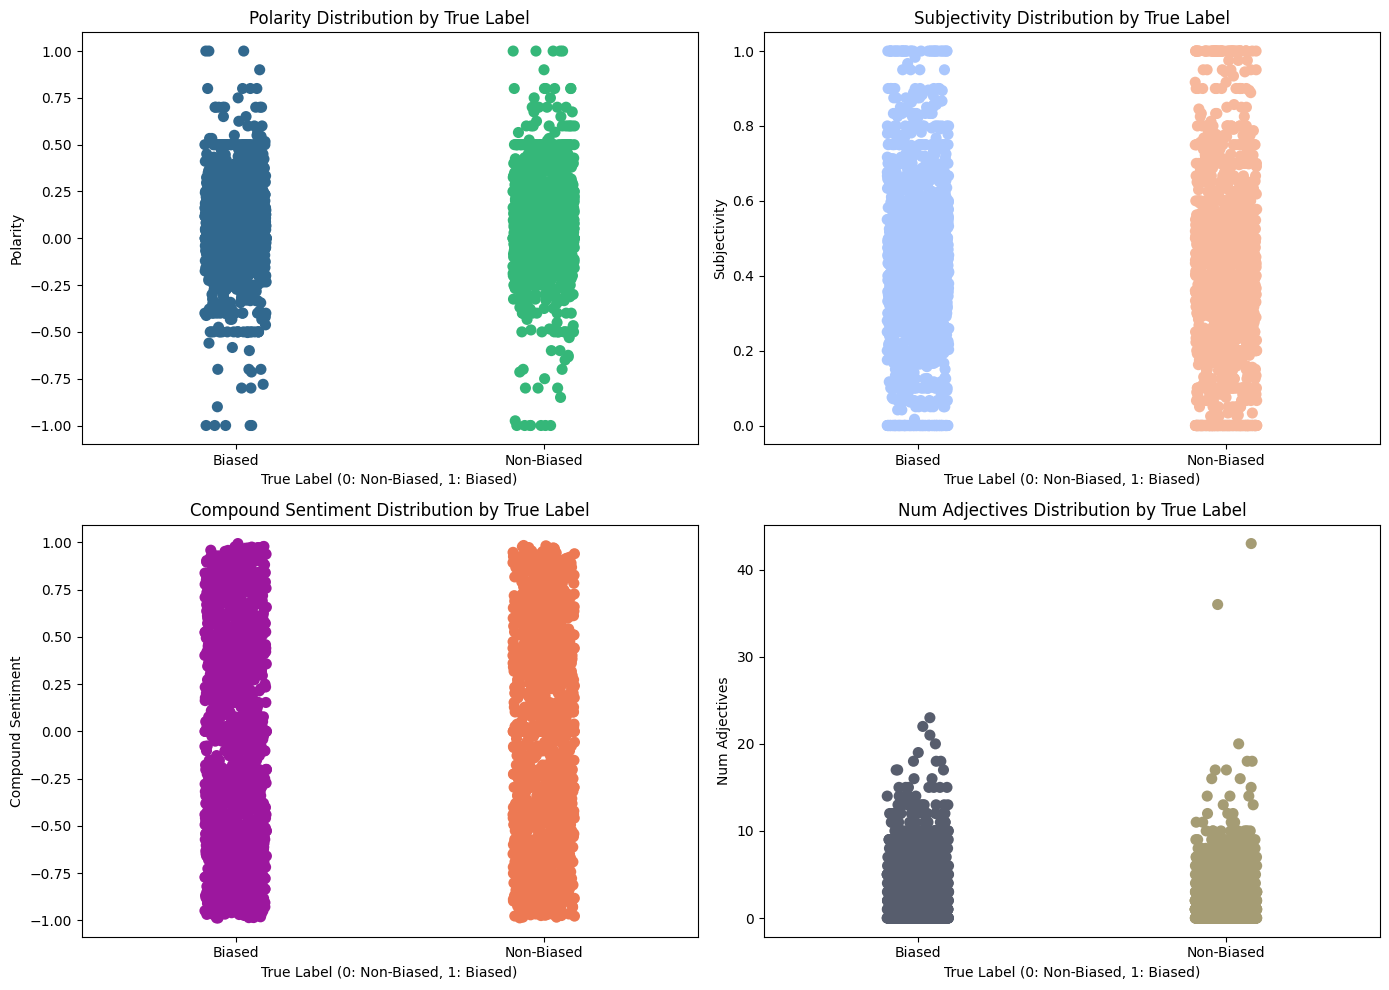

In [ ]:
# Set up a 2x2 grid for all features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"]
palettes = ["viridis", "coolwarm", "plasma", "cividis"]

for ax, feature, palette in zip(axes.flatten(), features, palettes):
    sns.stripplot(
        data=feature_df,
        x="True Label",
        y=feature,
        hue="True Label",
        palette=palette,
        jitter=True,
        size=8,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution by True Label")
    ax.set_xlabel("True Label (0: Non-Biased, 1: Biased)")
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


In [ ]:
from gensim.models import Word2Vec

# Step 1: Train Word2Vec embeddings on the filtered tokens
word2vec_model = Word2Vec(sentences=data['filtered_tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Step 2: Check the nearest neighbors for the word "gun"
if "gun" in word2vec_model.wv:
    similar_words = word2vec_model.wv.most_similar("gun", topn=10)
else:
    similar_words = "Word 'gun' not found in vocabulary."

similar_words


[('control', 0.7917343974113464),
 ('background', 0.7364085912704468),
 ('kidney', 0.7288398742675781),
 ('morningafter', 0.7109244465827942),
 ('violence', 0.7077151536941528),
 ('birth', 0.7044692039489746),
 ('spiraled', 0.6951629519462585),
 ('checks', 0.6906768679618835),
 ('centers', 0.6831082105636597),
 ('enshrining', 0.6729769706726074)]

In [ ]:
# --- Step 1: Prepare Data ---
MAX_VOCAB_SIZE = 10000  # Max vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Max length for padding
EMBEDDING_DIM = 100  # Embedding size

# Flatten filtered tokens into sentences
data['filtered_text'] = data['filtered_tokens'].apply(lambda x: ' '.join(x))

# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['filtered_text'])
sequences = tokenizer.texts_to_sequences(data['filtered_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Encode labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
data = data[data['bias_rating'].isin(label_mapping)]  # Filter valid bias ratings
y = data['bias_rating'].map(label_mapping).values
y = to_categorical(y, num_classes=3)  # One-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 2: Define the Model ---
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 3: Train the Model ---
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 4: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

KeyError: 'filtered_tokens'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


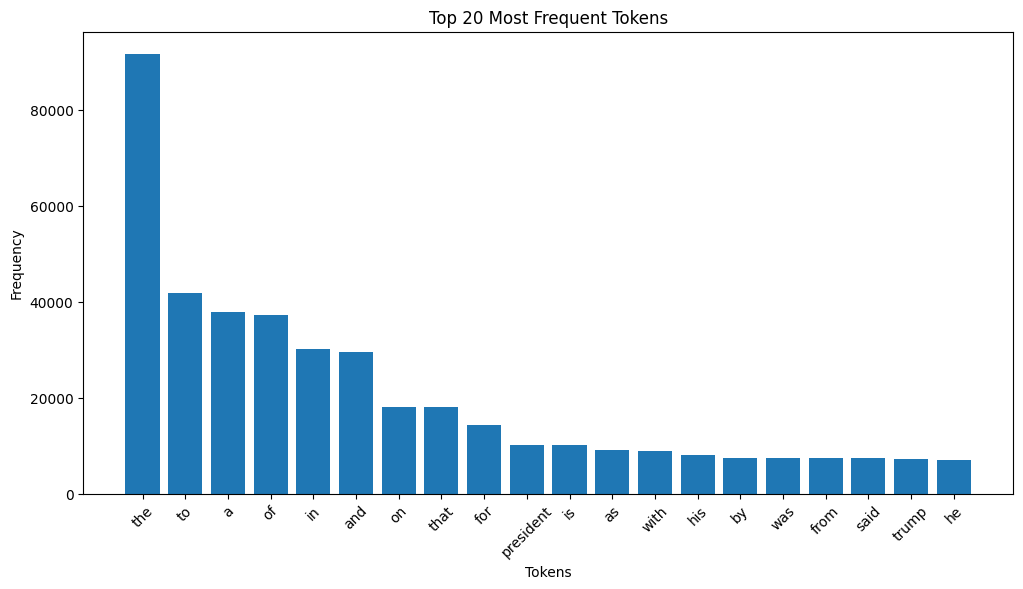

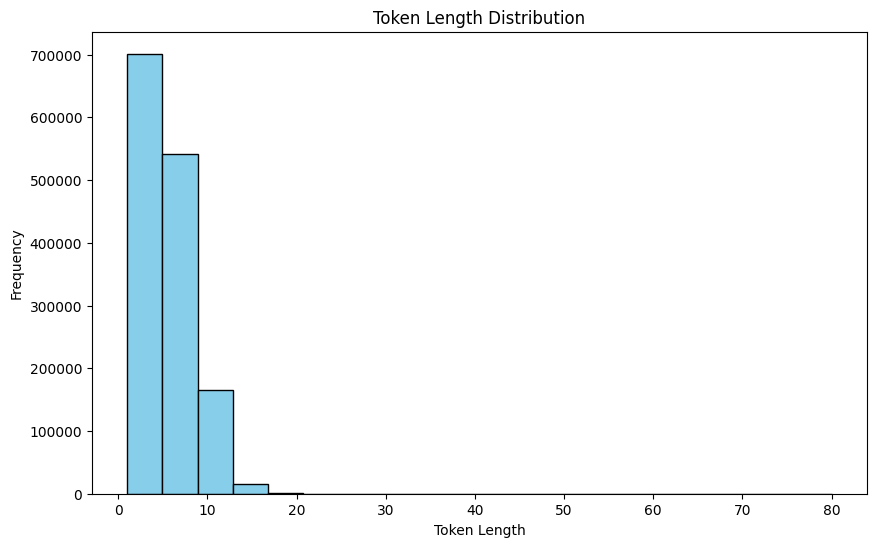

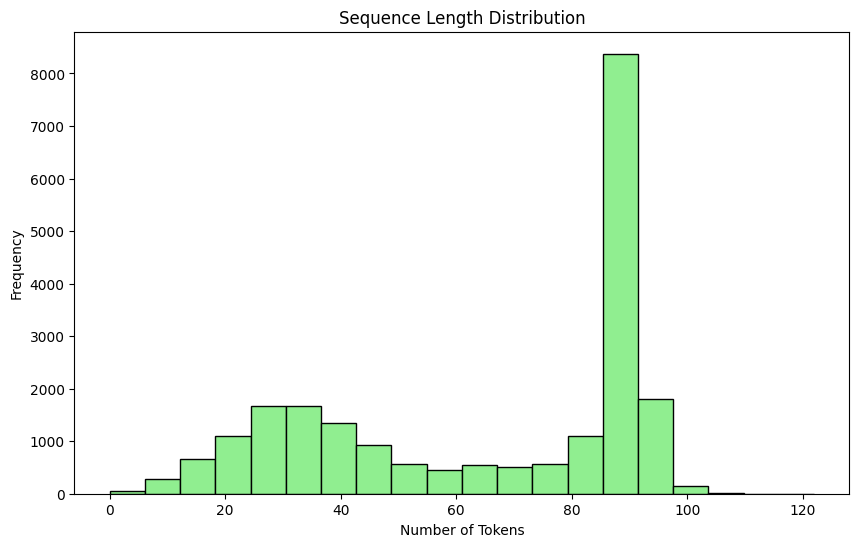

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


544/544 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.4683 - loss: 1.0447 - val_accuracy: 0.4716 - val_loss: 1.0373
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 60s 111ms/step - accuracy: 0.4637 - loss: 1.0400 - val_accuracy: 0.4712 - val_loss: 1.0300
Epoch 3/5
331/544 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.4949 - loss: 1.0130

KeyboardInterrupt: 

In [ ]:
# Install and import required libraries
!pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
import spacy

# --- Step 1: Load and Clean Data ---
# Load the dataset
file_path = "allsides_balanced_news_headlines-texts.csv"
data = pd.read_csv(file_path)

# Clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    return ""

data['clean_text'] = data['text'].apply(clean_text)

# --- Step 2: Tokenization with SpaCy ---
# Load SpaCy tokenizer
nlp = spacy.load("en_core_web_sm")

# Define tokenizer function
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_punct and not token.is_space]

# Tokenize text
data['tokens'] = data['clean_text'].apply(spacy_tokenizer)

# --- Step 3: Visualize Token Distributions ---
# 1. Token Frequency Distribution
all_tokens = [token for tokens in data['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
most_common = token_counts.most_common(20)

# Plot token frequency distribution
tokens, counts = zip(*most_common)
plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.title("Top 20 Most Frequent Tokens")
plt.ylabel("Frequency")
plt.xlabel("Tokens")
plt.xticks(rotation=45)
plt.show()

# 2. Token Length Distribution
token_lengths = [len(token) for token in all_tokens]
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# 3. Sequence Length Distribution
sequence_lengths = data['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.title("Sequence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# --- Step 4: Prepare Data for Training ---
# Convert tokens to sequences using Keras Tokenizer
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_text'])
sequences = tokenizer.texts_to_sequences(data['clean_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Encode labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
data = data[data['bias_rating'].isin(label_mapping)]  # Filter valid bias ratings
y = data['bias_rating'].map(label_mapping).values
y = to_categorical(y, num_classes=3)  # One-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 5: Build and Train the Model ---
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
EPOCHS = 5
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 6: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# --- Step 7: Print Summary ---
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


In [ ]:
print(data['bias_rating'].value_counts())


bias_rating
left      10275
right      7226
center     4253
Name: count, dtype: int64


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['bias_rating'].map(label_mapping)),
    y=data['bias_rating'].map(label_mapping)
)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict
)


Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 64s 115ms/step - accuracy: 0.4890 - loss: 1.0583 - val_accuracy: 0.4587 - val_loss: 1.0867
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 62s 113ms/step - accuracy: 0.4990 - loss: 1.0174 - val_accuracy: 0.4645 - val_loss: 1.0775
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 61s 113ms/step - accuracy: 0.5112 - loss: 0.9899 - val_accuracy: 0.4378 - val_loss: 1.1601
Epoch 4/5
246/544 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.5111 - loss: 0.9439

KeyboardInterrupt: 

In [ ]:
import numpy as np

# --- Step 1: Load GloVe Embeddings ---
def load_glove_embeddings(filepath, embedding_dim):
    """
    Load GloVe embeddings from a file.
    """
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

# Path to GloVe file (download from https://nlp.stanford.edu/projects/glove/)
glove_path = "glove.6B.100d.txt"  # Ensure this matches your downloaded file
EMBEDDING_DIM = 100  # Should match the GloVe embedding size
glove_embeddings = load_glove_embeddings(glove_path, EMBEDDING_DIM)

# --- Step 2: Create the Embedding Matrix ---
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))  # Random initialization for OOV words

# --- Step 3: Define the Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],  # Use pretrained embeddings
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  # Freeze embeddings
    ),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 4: Train the Model ---
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Loaded 278791 word vectors from GloVe.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


193/544 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.4638 - loss: 1.0614

KeyboardInterrupt: 

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# --- Step 1: Load GloVe Embeddings ---
def load_glove_embeddings(filepath, embedding_dim):
    """
    Load GloVe embeddings from a file.
    """
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

# Path to GloVe file (download from https://nlp.stanford.edu/projects/glove/)
glove_path = "glove.6B.100d.txt"  # Adjust this path as needed
EMBEDDING_DIM = 100
glove_embeddings = load_glove_embeddings(glove_path, EMBEDDING_DIM)

# --- Step 2: Create the Embedding Matrix ---
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))  # Random initialization for OOV words

# --- Step 3: Build the Model ---
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],  # Pretrained GloVe embeddings
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  # Freeze embeddings
    ),
    SpatialDropout1D(0.3),  # Randomly drop features in embedding space
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: left, center, right
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Step 4: Train the Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Loaded 400000 word vectors from GloVe.
Epoch 1/10
166/544 ━━━━━━━━━━━━━━━━━━━━ 2:29 396ms/step - accuracy: 0.4438 - loss: 1.0579

KeyboardInterrupt: 

In [ ]:
!pip install transformers


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the BERT Tokenizer ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Step 2: Tokenize the Data ---
def convert_data_to_examples(text, labels):
    """
    Converts text and labels to InputExample format for BERT.
    """
    return [InputExample(guid=None, text_a=t, label=l) for t, l in zip(text, labels)]

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    """
    Converts InputExamples to TensorFlow Dataset compatible with BERT.
    """
    input_ids, attention_masks, token_type_ids, labels = [], [], [], []

    for e in examples:
        inputs = tokenizer.encode_plus(
            e.text_a,
            None,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_token_type_ids=True
        )
        input_ids.append(inputs["input_ids"])
        attention_masks.append(inputs["attention_mask"])
        token_type_ids.append(inputs["token_type_ids"])
        labels.append(e.label)

    return tf.data.Dataset.from_tensor_slices((
        {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids},
        labels
    ))

# Convert examples to datasets
train_data = convert_examples_to_tf_dataset(train_examples, tokenizer)
test_data = convert_examples_to_tf_dataset(test_examples, tokenizer)

# Batch the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)#


from transformers import AdamWeightDecay

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
from transformers import AdamWeightDecay

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1588, in compute_loss  *
        return super().compute_loss(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss  **
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 275, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 854, in match_dtype_and_rank
        if (y_t.dtype.is_floating and y_p.dtype.is_floating) or (

    AttributeError: 'NoneType' object has no attribute 'dtype'


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AdamWeightDecay
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the BERT Tokenizer ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Step 2: Tokenize and Prepare Datasets ---
def encode_data(tokenizer, texts, labels, max_length=128):
    """
    Tokenizes the text and prepares TensorFlow datasets.
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
        },
        labels
    ))
    return dataset


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['bias_rating'], test_size=0.2, random_state=42, stratify=data['bias_rating']
)

# Define a mapping for the labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}

# Map string labels to integers
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)


# Encode data
train_data = encode_data(tokenizer, X_train, y_train)
test_data = encode_data(tokenizer, X_test, y_test)

# Batch and shuffle the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)

# --- Step 3: Load Pretrained BERT Model ---
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# --- Step 4: Compile and Train the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

# Use SparseCategoricalCrossentropy for integer labels
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 5: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1088/1088 [==============================] - 138s 110ms/step - loss: 0.9394 - accuracy: 0.5401 - val_loss: 0.9612 - val_accuracy: 0.5417
Epoch 2/3
1088/1088 [==============================] - 116s 107ms/step - loss: 0.4988 - accuracy: 0.7982 - val_loss: 1.6126 - val_accuracy: 0.5378
Epoch 3/3
136/136 [==============================] - 5s 39ms/step - loss: 2.1379 - accuracy: 0.5199
Test Accuracy: 0.5199


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import AdamWeightDecay
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Step 1: Load the RoBERTa Tokenizer ---
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# --- Step 2: Tokenize and Prepare Datasets ---
def encode_data(tokenizer, texts, labels, max_length=128):
    """
    Tokenizes the text and prepares TensorFlow datasets.
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
        },
        labels
    ))
    return dataset

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['bias_rating'], test_size=0.2, random_state=42, stratify=data['bias_rating']
)

# Define a mapping for the labels
label_mapping = {'left': 0, 'center': 1, 'right': 2}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Convert labels to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.int32)

# Encode data
train_data = encode_data(tokenizer, X_train, y_train)
test_data = encode_data(tokenizer, X_test, y_test)

# Batch and shuffle the datasets
train_data = train_data.shuffle(100).batch(32).repeat(2)
test_data = test_data.batch(32)

# --- Step 3: Load Pretrained RoBERTa Model ---
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

# --- Step 4: Compile the Model ---
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# --- Step 5: Train the Model ---
history = model.fit(train_data, epochs=3, validation_data=test_data)

# --- Step 6: Evaluate the Model ---
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
1088/1088 [==============================] - 140s 111ms/step - loss: 1.0439 - accuracy: 0.4714 - val_loss: 1.0408 - val_accuracy: 0.4723
Epoch 2/3
1088/1088 [==============================] - 118s 108ms/step - loss: 1.0432 - accuracy: 0.4721 - val_loss: 1.0410 - val_accuracy: 0.4723
Epoch 3/3
136/136 [==============================] - 5s 39ms/step - loss: 1.0406 - accuracy: 0.4723
Test Accuracy: 0.4723


In [ ]:
# Filter data into subsets
left_subset = data[data['bias_rating'] == 'left']
center_subset = data[data['bias_rating'] == 'center']
right_subset = data[data['bias_rating'] == 'right']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def tokenize_and_vectorize(subset, max_features=5000):
    vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english', max_features=max_features)
    dtm = vectorizer.fit_transform(subset['clean_text'])
    return dtm, vectorizer

# Vectorize each subset
left_dtm, left_vectorizer = tokenize_and_vectorize(left_subset)
center_dtm, center_vectorizer = tokenize_and_vectorize(center_subset)
right_dtm, right_vectorizer = tokenize_and_vectorize(right_subset)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda(dtm, num_topics=10):
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    return lda_model

# Fit LDA models
left_lda = fit_lda(left_dtm)
center_lda = fit_lda(center_dtm)
right_lda = fit_lda(right_dtm)


In [ ]:
def display_topics(lda_model, vectorizer, num_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        topics[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[-num_words:]]
    return topics

# Get topics for each subset
left_topics = display_topics(left_lda, left_vectorizer)
center_topics = display_topics(center_lda, center_vectorizer)
right_topics = display_topics(right_lda, right_vectorizer)

print("Left Topics:", left_topics)
print("Center Topics:", center_topics)
print("Right Topics:", right_topics)


Left Topics: {'Topic 0': ['military', 'putin', 'prices', 'ukrainian', 'mcconnell', 'president', 'russia', 'said', 'ukraine', 'russian'], 'Topic 1': ['monday', 'states', 'million', 'said', 'justice', 'company', 'new', 'federal', 'supreme', 'court'], 'Topic 2': ['told', 'campaign', 'white', 'house', 'trumps', 'news', 'said', 'donald', 'president', 'trump'], 'Topic 3': ['white', 'said', 'house', 'federal', 'care', 'health', 'administration', 'trump', 'law', 'president'], 'Topic 4': ['students', 'florida', 'states', 'texas', 'governor', 'gun', 'gov', 'state', 'school', 'new'], 'Topic 5': ['deal', 'china', 'american', 'world', 'biden', 'said', 'trump', 'states', 'united', 'president'], 'Topic 6': ['sunday', 'state', 'man', 'thursday', 'shooting', 'city', 'killed', 'people', 'police', 'said'], 'Topic 7': ['committee', 'said', 'attorney', 'general', 'biden', 'donald', 'house', 'election', 'president', 'trump'], 'Topic 8': ['jobs', 'million', 'health', 'people', 'said', 'vaccine', 'new', 'pand

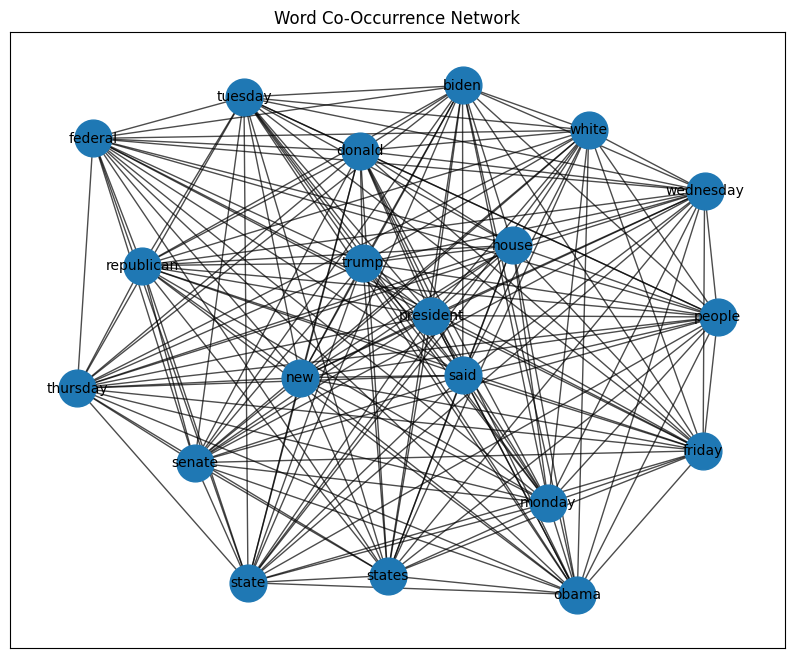

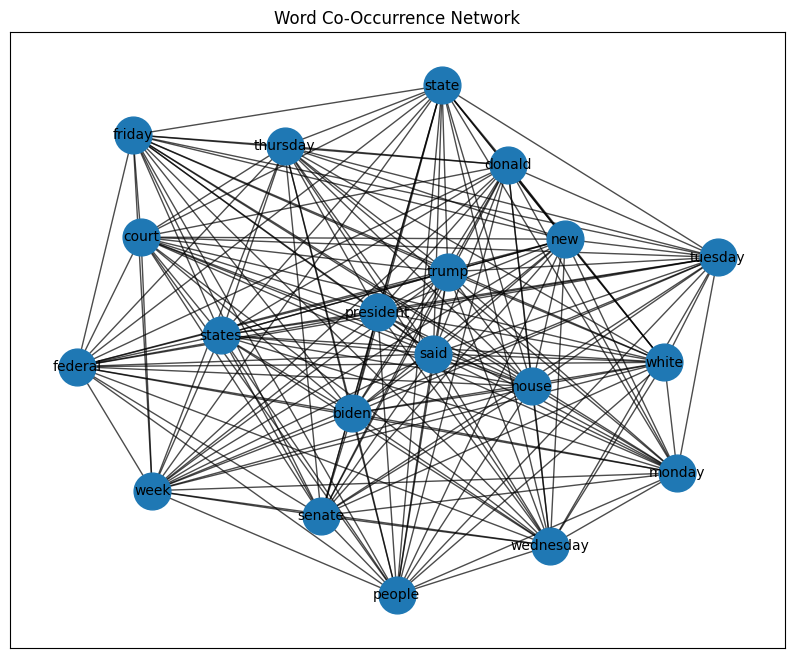

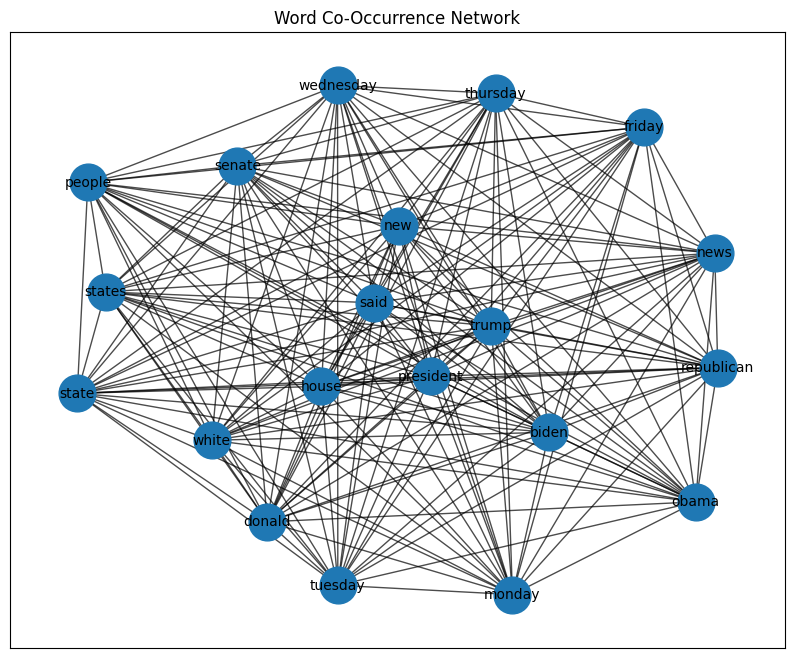

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_cooccurrence(dtm, vectorizer, top_n=20):
    # Get the top words
    sum_words = dtm.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    top_words = [word for word, freq in sorted_words]

    # Build co-occurrence matrix
    cooccurrence = (dtm[:, [vectorizer.vocabulary_[word] for word in top_words]].T *
                    dtm[:, [vectorizer.vocabulary_[word] for word in top_words]]).toarray()

    # Create graph
    G = nx.Graph()
    for i, word in enumerate(top_words):
        for j, co in enumerate(cooccurrence[i]):
            if co > 0 and i != j:
                G.add_edge(word, top_words[j], weight=co)

    # Plot graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Word Co-Occurrence Network")
    plt.show()

# Plot co-occurrence for each subset
plot_cooccurrence(left_dtm, left_vectorizer)
plot_cooccurrence(center_dtm, center_vectorizer)
plot_cooccurrence(right_dtm, right_vectorizer)
